In [162]:
import scipy.io
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

# Model Architecture 

- **Two-layered MLP**
- **Input layer ($a^{[0]}$)**: 400 units corresponding to the 400 pixels in each 20x20 input image 
- **Hidden layer ($a^{[1]}$)**: 10 units with ReLU activation
- **Output layer ($a^{[2]}$)**: 10 units corresponding to the ten digit classes with softmax activation.

**Forward propagation**

$$Z^{[1]} = W^{[1]} X + b^{[1]}$$
$$A^{[1]} = g_{\text{ReLU}}(Z^{[1]}))$$
$$Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]}$$
$$A^{[2]} = g_{\text{softmax}}(Z^{[2]})$$

**Backward propagation**

$$dZ^{[2]} = A^{[2]} - Y$$
$$dW^{[2]} = \frac{1}{m} dZ^{[2]} A^{[1]T}$$
$$dB^{[2]} = \frac{1}{m} \Sigma {dZ^{[2]}}$$
$$dZ^{[1]} = W^{[2]T} dZ^{[2]} .* g^{[1]\prime} (z^{[1]})$$
$$dW^{[1]} = \frac{1}{m} dZ^{[1]} A^{[0]T}$$
$$dB^{[1]} = \frac{1}{m} \Sigma {dZ^{[1]}}$$

**Parameter updates**

$$W^{[2]} := W^{[2]} - \alpha dW^{[2]}$$
$$b^{[2]} := b^{[2]} - \alpha db^{[2]}$$
$$W^{[1]} := W^{[1]} - \alpha dW^{[1]}$$
$$b^{[1]} := b^{[1]} - \alpha db^{[1]}$$

**Vars and shapes**

Forward propagation 

- $A^{[0]} = X$: 400 x m
- $Z^{[1]} \sim A^{[1]}$: 10 x m
- $W^{[1]}$: 10 x 400 (as $W^{[1]} A^{[0]} \sim Z^{[1]}$)
- $B^{[1]}$: 10 x 1
- $Z^{[2]} \sim A^{[2]}$: 10 x m
- $W^{[1]}$: 10 x 10 (as $W^{[2]} A^{[1]} \sim Z^{[2]}$)
- $B^{[2]}$: 10 x 1

backpropagation

- $dZ^{[2]}$: 10 x m ($~A^{[2]}$)
- $dW^{[2]}$: 10 x 10
- $dB^{[2]}$: 10 x 1
- $dZ^{[1]}$: 10 x m ($~A^{[1]}$)
- $dW^{[1]}$: 10 x 10
- $dB^{[1]}$: 10 x 1

# Building the model 

In [70]:
def init_params():
    """ generates the initial weights and biases for a simple two layered MLP"""
    W1 = np.random.rand(10,400) - 0.5
    b1 = np.random.rand(10,1) - 0.5
    W2 = np.random.rand(10,10) - 0.5
    b2 = np.random.rand(10,1) - 0.5
    return W1, b1, W2, b2

def ReLu(Z):
    """Rectified linear unit. returns 0 for inputs smaller than zero and Z for inputs greater than 1
    params:
    Z: sum of weights and biases of input layer"""
    return np.maximum(Z,0)

def softmax(Z):
    """converts a vector of K real numbers into a probability distribution of K possible outcomes."""
    A = np.exp(Z) / sum(np.exp(Z))
    return A
    
def forward_prop(W1,b1,W2,b2,X):
    Z1 = W1.dot(X) + b1
    A1 = ReLu(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

def ReLu_deriv(Z):
    return Z > 0

def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y):
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y   #error of output layer 
    dW2 = 1 / m * dZ2.dot(A1.T) #gradient of weights of output layer 
    db2 = 1 / m * np.sum(dZ2) #gradient of biases of output layer 
    dZ1 = W2.T.dot(dZ2) * ReLu_deriv(Z1) #error of hidden layer
    dW1 = 1 / m * dZ1.dot(X.T) #gradient of weights of hidden layer 
    db1 = 1 / m * np.sum(dZ1) #gradient of biases of hidden layer
    return dW1, db1, dW2, db2 

def update_params (W1, b1, W2, b2, dW1, db1, dW2, db2, eta):
    W1 = W1 - eta * dW1
    b1 = b1 - eta * db1
    W2 = W2 - eta * dW2
    b2 = b2 - eta * db2
    return W1, b1, W2, b2 




In [68]:
def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    #print(predictions, Y)
    return np.sum(predictions == Y) / Y.size

def gradient_descent (X, Y, eta, iterations):
    W1, b1, W2, b2 = init_params()
    for iteration in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, eta)
        if iteration % 10 == 0:
            print("Iteration: ", iteration)
            predictions = get_predictions(A2)
            print(f"Accuracy:{get_accuracy(predictions, Y)*100}%")
            print("==========")
    return W1, b1, W2, b2

# Loading and preprocessing data

In [7]:
hoda_raw = scipy.io.loadmat('Data_hoda_full.mat')

In [8]:
X = np.squeeze(hoda_raw['Data'])
Y = np.squeeze(hoda_raw['labels'])

In [9]:
X_resized = [resize(sample,(20,20)) for sample in X]
X_resized = np.array(X_resized)
X = X_resized
#hoda = pd.DataFrame(zip(X,Y),columns=['instances','labels'])

In [10]:
a,b,c = X.shape
X = np.reshape(X, (a , b*c))

In [107]:
m , n = X.shape

In [12]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.33333,random_state=42)

In [110]:
x_train.shape

(40000, 400)

# Training The Model

In [ ]:
eta = 0.2

In [ ]:
W1, b1, W2, b2 = gradient_descent(x_train.T,y_train,eta,1000)

# Testing The Model 

In [ ]:
Z1, A1, Z2, A2 = forward_prop(W1,b1,W2,b2,x_test.T)

In [ ]:
predictions = get_predictions(A2)

In [ ]:
accuracy = get_accuracy(predictions,y_test)
print(accuracy)

In [ ]:
counter = 0
for i in range(len(y_test)):
    if predictions[i] != y_test[i]:
        #print(f"INDEX: {i} \nPREDICTED: {predictions[i]}\nTRUE LABEL: {y_test[i]}\n=============")
        counter += 1
print(counter)

In [ ]:
print(f"TOTAL NUMBER OF WRONG PREDICTIONS: {counter}")

## Doing the same thing using SKLearn.neural_network.MLPClassifier

In [52]:
eta = 0.5

In [53]:
mlp = MLPClassifier(hidden_layer_sizes=(10,),learning_rate_init = eta, max_iter=1000, tol=0.0001,verbose=True)
history = mlp.fit(x_train, y_train)

Iteration 1, loss = 2.44989463
Iteration 2, loss = 2.32875585
Iteration 3, loss = 2.32963095
Iteration 4, loss = 2.32513026
Iteration 5, loss = 2.32646067
Iteration 6, loss = 2.32788395
Iteration 7, loss = 2.33077991
Iteration 8, loss = 2.32505456
Iteration 9, loss = 2.32505667
Iteration 10, loss = 2.32661939
Iteration 11, loss = 2.32618845
Iteration 12, loss = 2.32434503
Iteration 13, loss = 2.32317665
Iteration 14, loss = 2.32613727
Iteration 15, loss = 2.32369192
Iteration 16, loss = 2.32453447
Iteration 17, loss = 2.32295668
Iteration 18, loss = 2.32243333
Iteration 19, loss = 2.32751386
Iteration 20, loss = 2.32902111
Iteration 21, loss = 2.32444044
Iteration 22, loss = 2.32208985
Iteration 23, loss = 2.32358761
Iteration 24, loss = 2.32283454
Iteration 25, loss = 2.32308439
Iteration 26, loss = 2.32271638
Iteration 27, loss = 2.32385773
Iteration 28, loss = 2.32371912
Iteration 29, loss = 2.32238201
Iteration 30, loss = 2.32156246
Iteration 31, loss = 2.31993555
Iteration 32, los

In [54]:
predictions = history.predict(x_train)
accuracy = get_accuracy(predictions,y_train)
print(accuracy)

0.100425


Text(0, 0.5, 'Loss')

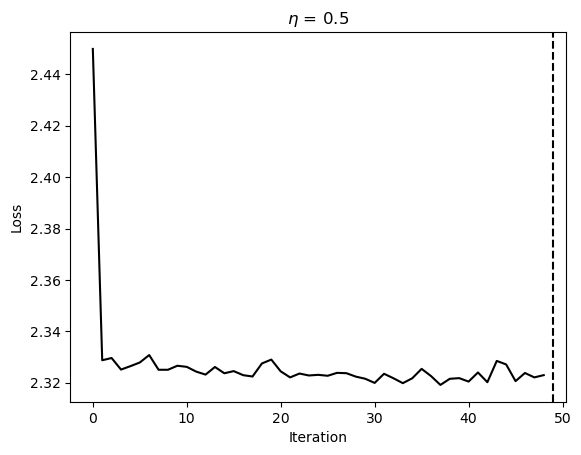

In [55]:
plt.plot(history.loss_curve_, label='Training loss',color='black')
plt.title(f'$\eta$ = {eta}')
plt.axvline(x=history.n_iter_, color='black', linestyle='--', label='Convergence Iteration')
plt.xlabel('Iteration')
plt.ylabel('Loss')
#plt.legend()
#plt.savefig(f'{eta}s.tiff')


In [ ]:
n_iter = history.n_iter_
print(f"Solver converged after {n_iter} iterations")

In [ ]:
predictions = history.predict(x_test)
accuracy = get_accuracy(predictions,y_test)
print(accuracy)

In [72]:
def gradient_descent2 (X, Y, eta, iterations):
    W1, b1, W2, b2 = init_params()
    loss_curve = []  # create an empty list to store the loss values
    for iteration in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, eta)
        loss = np.mean((A2 - one_hot(Y)) ** 2)  # calculate the mean squared error for the current iteration
        loss_curve.append(loss)  # append the loss value to the list
        if iteration % 10 == 0:
            print("Iteration: ", iteration)
            predictions = get_predictions(A2)
            print(f"Accuracy:{get_accuracy(predictions, Y)*100}%")
            print("==========")
#     plt.plot(loss_curve)  # plot the loss curve
#     plt.title('Loss Curve')
#     plt.xlabel('Iteration')
#     plt.ylabel('Loss')
#     plt.show()
    return W1, b1, W2, b2 , loss_curve

In [158]:
eta = 2
iterations = 5000
W1, b1, W2, b2 , loss_curve = gradient_descent2(x_train.T,y_train,eta,iterations)

Iteration:  0
Accuracy:11.0075%
Iteration:  10
Accuracy:20.955%
Iteration:  20
Accuracy:24.127499999999998%
Iteration:  30
Accuracy:34.715%
Iteration:  40
Accuracy:39.8225%
Iteration:  50
Accuracy:34.37%
Iteration:  60
Accuracy:40.19%
Iteration:  70
Accuracy:38.6625%
Iteration:  80
Accuracy:40.38%
Iteration:  90
Accuracy:28.925%
Iteration:  100
Accuracy:39.332499999999996%
Iteration:  110
Accuracy:31.665%
Iteration:  120
Accuracy:39.485%
Iteration:  130
Accuracy:38.975%
Iteration:  140
Accuracy:29.115000000000002%
Iteration:  150
Accuracy:29.145%
Iteration:  160
Accuracy:29.1625%
Iteration:  170
Accuracy:29.189999999999998%
Iteration:  180
Accuracy:29.207499999999996%
Iteration:  190
Accuracy:29.220000000000002%
Iteration:  200
Accuracy:29.24%
Iteration:  210
Accuracy:29.24%
Iteration:  220
Accuracy:29.2425%
Iteration:  230
Accuracy:29.23%
Iteration:  240
Accuracy:29.2275%
Iteration:  250
Accuracy:29.152499999999996%
Iteration:  260
Accuracy:27.060000000000002%
Iteration:  270
Accuracy

Iteration:  1730
Accuracy:30.3975%
Iteration:  1740
Accuracy:24.560000000000002%
Iteration:  1750
Accuracy:29.7225%
Iteration:  1760
Accuracy:29.79%
Iteration:  1770
Accuracy:29.817500000000003%
Iteration:  1780
Accuracy:29.84%
Iteration:  1790
Accuracy:21.915000000000003%
Iteration:  1800
Accuracy:29.835%
Iteration:  1810
Accuracy:29.79%
Iteration:  1820
Accuracy:29.8475%
Iteration:  1830
Accuracy:29.677500000000002%
Iteration:  1840
Accuracy:30.0375%
Iteration:  1850
Accuracy:30.607499999999998%
Iteration:  1860
Accuracy:20.3425%
Iteration:  1870
Accuracy:29.73%
Iteration:  1880
Accuracy:30.09%
Iteration:  1890
Accuracy:30.94%
Iteration:  1900
Accuracy:31.105%
Iteration:  1910
Accuracy:29.835%
Iteration:  1920
Accuracy:19.935%
Iteration:  1930
Accuracy:19.787499999999998%
Iteration:  1940
Accuracy:29.470000000000002%
Iteration:  1950
Accuracy:29.635%
Iteration:  1960
Accuracy:29.665000000000003%
Iteration:  1970
Accuracy:29.659999999999997%
Iteration:  1980
Accuracy:29.6925%
Iteratio

Iteration:  3380
Accuracy:29.8425%
Iteration:  3390
Accuracy:29.904999999999998%
Iteration:  3400
Accuracy:29.799999999999997%
Iteration:  3410
Accuracy:30.2%
Iteration:  3420
Accuracy:31.759999999999998%
Iteration:  3430
Accuracy:30.0%
Iteration:  3440
Accuracy:29.815%
Iteration:  3450
Accuracy:29.8525%
Iteration:  3460
Accuracy:29.945%
Iteration:  3470
Accuracy:30.002499999999998%
Iteration:  3480
Accuracy:30.990000000000002%
Iteration:  3490
Accuracy:29.862499999999997%
Iteration:  3500
Accuracy:30.067500000000003%
Iteration:  3510
Accuracy:31.912499999999998%
Iteration:  3520
Accuracy:20.215%
Iteration:  3530
Accuracy:29.2825%
Iteration:  3540
Accuracy:29.45%
Iteration:  3550
Accuracy:29.665000000000003%
Iteration:  3560
Accuracy:29.727500000000003%
Iteration:  3570
Accuracy:29.7475%
Iteration:  3580
Accuracy:29.755%
Iteration:  3590
Accuracy:29.7875%
Iteration:  3600
Accuracy:29.7875%
Iteration:  3610
Accuracy:29.785%
Iteration:  3620
Accuracy:29.7975%
Iteration:  3630
Accuracy:29

In [159]:
Z1, A1, Z2, A2 = forward_prop(W1,b1,W2,b2,x_train.T)
predictions = get_predictions(A2)
accuracy = get_accuracy(predictions,y_train)
print(f'training accuracy ={accuracy}')

training accuracy =0.311125


In [160]:
Z1, A1, Z2, A2 = forward_prop(W1,b1,W2,b2,x_test.T)
predictions = get_predictions(A2)
accuracy = get_accuracy(predictions,y_test)
print(f'test accuracy ={accuracy}')

test accuracy =0.31015


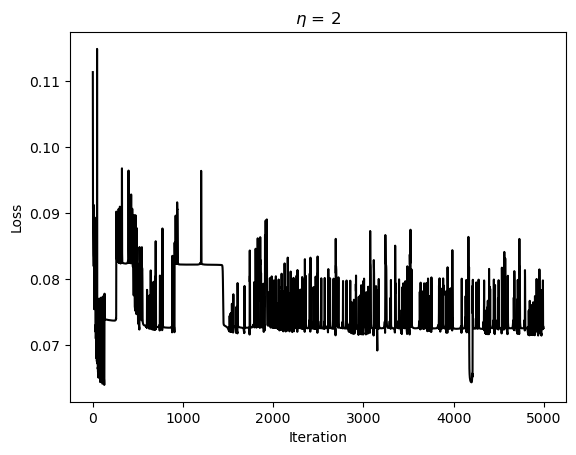

In [161]:
plt.plot(loss_curve,'black')  # plot the loss curve
plt.title(f'$\eta$ = {eta}')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.savefig(f'my_model_{eta}.tiff')